In [1]:
import warnings
import torch

from gflownet.config import init_empty, Config
from rdkit.Chem.Draw import MolsToGridImage
import pathlib

In [2]:
from molecule import MoleculeTrainer

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


Run the model with comparing openpom probability vectors as reward

In [3]:
import pandas as pd
import random
import datetime

In [4]:
# Get vanilla molecules

df = pd.read_csv("data.csv")
df.head()

,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
0,CC(O)CN,fishy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CCC(=O)C(=O)O,fatty;lactonic;sweet;caramellic;creamy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)CCc1ccccc1,rose;floral;fatty;sweet;musk;cinnamon;balsamic,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OCc1ccc(O)cc1,medicinal;phenolic;fruity;nutty;bitter;sweet;a...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,O=Cc1ccc(O)cc1,phenolic;woody;nutty;vanilla;hay;metallic;swee...,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [5]:
len(df)*0.01

49.83

In [6]:
vanilla_mols_df = df.loc[df['vanilla'] == 1]
vanilla_mols_df.head()
#vanilla = index 64


,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
4,O=Cc1ccc(O)cc1,phenolic;woody;nutty;vanilla;hay;metallic;swee...,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
26,COc1ccccc1O,medicinal;savory;phenolic;woody;smoky;vanilla;...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
32,O=C1CCc2ccccc2O1,herbal;nutty;vanilla;coumarinic;hay;tobacco;sw...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
64,COc1cc(C=O)ccc1O,chocolate;vanilla;creamy;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
67,COc1cc(C(C)=O)ccc1O,vanilla;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
vanilla_mols_df.loc[4]

nonStereoSMILES                                       O=Cc1ccc(O)cc1
descriptors        phenolic;woody;nutty;vanilla;hay;metallic;swee...
alcoholic                                                          0
aldehydic                                                          0
alliaceous                                                         0
                                         ...                        
warm                                                               0
waxy                                                               0
weedy                                                              0
winey                                                              0
woody                                                              1
Name: 4, Length: 140, dtype: object

In [8]:
import numpy as np
a = np.array(vanilla_mols_df.index)
random.shuffle(a)
a


array([1003, 1162, 1103, 1024,  254,  634, 2498, 4703,   67, 3904, 1006,
        696, 2525, 4563,  163,  170,  398,  150, 4068,  532,  928, 3020,
       1184, 2491, 1140, 3039, 4638, 2320, 2845,  212,  959, 2419, 2725,
          4, 3903, 1740,  448,  777, 1051, 4951, 2802, 4185, 1835,  243,
        399, 4071,  392, 3730, 2193,   64, 2288,  731, 2261,   26,   32,
       2901, 2456, 1970, 2849, 4899,  403, 3000,  155, 4337, 2018, 1933,
        390, 1174, 1884,  396, 1563,  738, 1119, 1474, 2250, 1789, 4356,
       2492, 1473, 1721, 1370,  633, 2386,  211, 2450,  395, 4564,  944,
       1862,  719,   85,  179,  547, 1985, 2844, 2486,  447,  201, 3154,
        835, 1297, 1779,  393,  387, 4866, 4651, 2938,  844, 4272,  389,
       4419], dtype=int64)

In [9]:
torch.tensor(vanilla_mols_df.iloc[4][2:]).float()

C:\Users\paulj\AppData\Local\Temp\ipykernel_21004\2779111957.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(vanilla_mols_df.iloc[4][2:]).float()


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
# 70% training data 

round(len(vanilla_mols_df)*0.7)
vanilla_smiles_trainig= list(vanilla_mols_df["nonStereoSMILES"])
vanilla_smiles_trainig = random.sample(vanilla_smiles_trainig, round(len(vanilla_mols_df)*0.7))
random.shuffle(vanilla_smiles_trainig)
vanilla_smiles_test = []
for i in vanilla_mols_df["nonStereoSMILES"]:
    if i not in vanilla_smiles_trainig:
        vanilla_smiles_test.append(i)

len(vanilla_smiles_trainig),round(len(vanilla_mols_df)*0.7),len(vanilla_mols_df["nonStereoSMILES"]),len(vanilla_smiles_test)


(78, 78, 111, 33)

In [11]:
datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

'2024-11-25_18:55:56'

In [12]:
from rdkit.Chem.AtomPairs.Utils import CosineSimilarity
from rdkit import Chem



In [13]:
Chem.RDKFingerprint(Chem.MolFromSmiles("COc1cc(C=O)ccc1O"))


In [14]:
from pom_models.functions import fragance_propabilities_from_smiles

In [15]:
vanilla_mols_df.keys()[-9]

'vanilla'

In [16]:
haha_df = vanilla_mols_df.head()
haha_df

,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
4,O=Cc1ccc(O)cc1,phenolic;woody;nutty;vanilla;hay;metallic;swee...,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
26,COc1ccccc1O,medicinal;savory;phenolic;woody;smoky;vanilla;...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
32,O=C1CCc2ccccc2O1,herbal;nutty;vanilla;coumarinic;hay;tobacco;sw...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
64,COc1cc(C=O)ccc1O,chocolate;vanilla;creamy;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
67,COc1cc(C(C)=O)ccc1O,vanilla;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [17]:
type(haha_df)==pd.DataFrame
type(None)==pd.DataFrame

False

In [18]:
from fragments import FRAGMENTS_OPENPOM_VANILLA

In [19]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Run on cpu
dev = torch.device('cpu')

# Vanillin
vanillin_smiles = ["COc1cc(C=O)ccc1O"] #vanilla_smiles_trainig #["[H]C(=O)C1=CC(OC)=C(O)C=C1"]



# Initialize model
config = init_empty(Config())
config.print_every = 1
config.log_dir = f"long_run_properties_{datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')}"
config.device = dev
config.num_training_steps = 500
config.num_workers = 0
config.num_validation_gen_steps = 1
config.overwrite_existing_exp=False
config.checkpoint_every = 100
config.algo.max_nodes = 6 #12 # 95 quantil
config.store_all_checkpoints = True

trial = MoleculeTrainer(config,dataframe=haha_df,fragments=FRAGMENTS_OPENPOM_VANILLA, print_config=True)
#trial.run()



"""# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

  
state = {
    "models_state_dict": [trial.model.state_dict()],
    "cfg": trial.cfg,
    "env_ctx": trial.model.env_ctx,
    #"model": trial.model,
}
if trial.sampling_model is not trial.model:
    state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
with open(fn, "wb") as fd:
    torch.save(
        state,
        fd,
    )"""



Hyperparameters:

desc: noDesc
log_dir: long_run_properties_2024-11-25__18_55_57
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: 100
store_all_checkpoints: true
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 500
num_workers: 0
hostname: null
pickle_mp_messages: false
git_hash: f106cde
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 6
  max_edges: 128
  illegal_action_logreward: -1.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_

'# Generate molecules\ntrajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)\nobjs = [trial.ctx.graph_to_obj(i[\'result\']) for i in trajs]\nobj_props, _ = trial.task.compute_obj_properties(objs)\nlog_rewards = trial.task.cond_info_to_logreward({\'beta\': torch.ones(len(trajs))}, obj_props)\nMolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f\'reward: {r.exp().item():.2f}\' for r in log_rewards[:25]])\n\n  \nstate = {\n    "models_state_dict": [trial.model.state_dict()],\n    "cfg": trial.cfg,\n    "env_ctx": trial.model.env_ctx,\n    #"model": trial.model,\n}\nif trial.sampling_model is not trial.model:\n    state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]\nfn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"\nwith open(fn, "wb") as fd:\n    torch.save(\n        state,\n        fd,\n    )'

In [20]:
trial.task.reward_function_(Chem.MolFromSmiles("CNC(=O)C1CCCCC1n1ccc(C2CC(C3CCN(C4CCCCC4)CC3)OC2n2nc(S(N)(=O)=O)c(C=C(C)C)c2C2CCCC(c3cc(-c4ccccc4)c[nH]3)C2)nc1=O"))

0.0001685514788701828

In [21]:
trial.training_data.df

,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
4,O=Cc1ccc(O)cc1,phenolic;woody;nutty;vanilla;hay;metallic;swee...,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
26,COc1ccccc1O,medicinal;savory;phenolic;woody;smoky;vanilla;...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
32,O=C1CCc2ccccc2O1,herbal;nutty;vanilla;coumarinic;hay;tobacco;sw...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
64,COc1cc(C=O)ccc1O,chocolate;vanilla;creamy;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
67,COc1cc(C(C)=O)ccc1O,vanilla;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [22]:
trial.training_data.df.index
idcs = np.array(trial.training_data.df.index)
print(idcs)
import random
random_gen = random.Random(123)
random_gen.shuffle(idcs)
idcs
trial.training_data.idcs

[ 4 26 32 64 67]


array([67,  4, 26, 32, 64], dtype=int64)

In [23]:
trial.task.training_data_smiles

['COc1cc(C(C)=O)ccc1O',
 'O=Cc1ccc(O)cc1',
 'COc1ccccc1O',
 'O=C1CCc2ccccc2O1',
 'COc1cc(C=O)ccc1O']

In [24]:
[trial.task.reward_function_(Chem.MolFromSmiles(i)) for i in vanilla_mols_df["nonStereoSMILES"]]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.24242987814248498,
 0.43818361670960415,
 0.2856669344189426,
 0.25392177191302573,
 0.31991015864327066,
 0.28701261528908095,
 0.36351860744883185,
 0.2921544604965164,
 0.258371711202641,
 0.2420894015579946,
 0.2354419956867582,
 0.25550840283691617,
 0.29670097296920817,
 0.32952903297581193,
 0.3193337323230837,
 0.31858174273730716,
 0.25711899848305597,
 0.3187455325007087,
 0.31831975389670114,
 0.28068037019357683,
 0.21901285482929866,
 0.2964885601936291,
 0.2880138638845474,
 0.21290691491771158,
 0.2726971506747347,
 0.2751971384804031,
 0.3478455841042648,
 0.3262099537368415,
 0.29848443116352513,
 0.27570843143647167,
 0.27039360572358556,
 0.2522062538676172,
 0.33651355880857187,
 0.26572822882108493,
 0.27562207473132444,
 0.2701621911446155,
 0.33399041953161535,
 0.2511148057391513,
 0.14155197540115808,
 0.25269276614794284,
 0.20554299951291616,
 0.32538962258830456,
 0.3295726298834633,
 0.29718696642957065,
 0.33135841888810275

In [25]:
import matplotlib.pyplot as plt

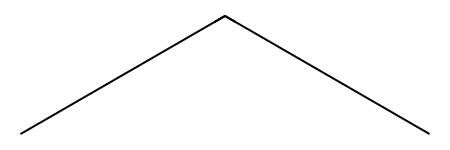

In [26]:
rew = np.linspace(0,1,100)
mm1 = Chem.MolFromSmiles("CCC")
mm2 = Chem.MolFromSmiles("CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC")
mm1

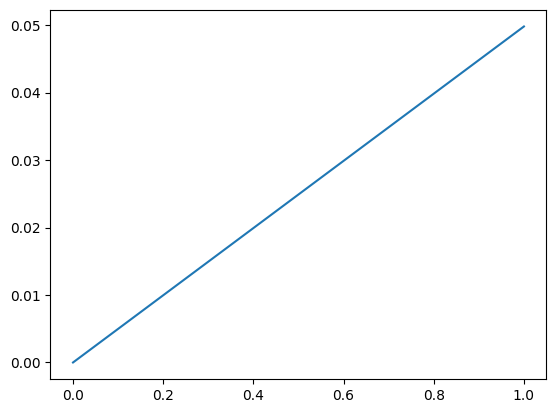

In [27]:
plt.plot(rew, trial.task.large_molecule_penalty(rew,mm2))

In [28]:
mm2.GetNumAtoms()

45

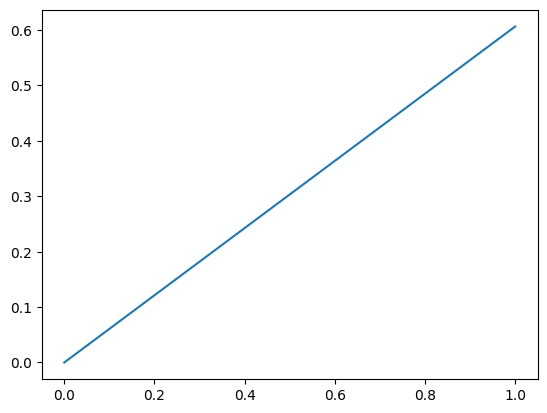

In [29]:
plt.plot(rew,  rew*np.exp(-0.1*(20-15)))

In [30]:
trial.run()

25/11/2024 18:56:14 - INFO - logger - Starting training
25/11/2024 18:56:28 - INFO - logger - iteration 1 : offline_loss:0.00 online_loss:226.21 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.16 loss:226.21 n_loss:0.00 tb_loss:226.21 batch_entropy:26.08 traj_lens:11.47 grad_norm:236.42 grad_norm_clip:64.99 sampled_reward_avg:0.44 train_time:1.56 time_spent:13.61
25/11/2024 18:56:41 - INFO - logger - iteration 2 : offline_loss:0.00 online_loss:187.79 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.13 loss:187.79 n_loss:0.00 tb_loss:187.79 batch_entropy:23.55 traj_lens:10.62 grad_norm:252.91 grad_norm_clip:65.58 sampled_reward_avg:0.46 train_time:1.45 time_spent:12.49
25/11/2024 18:56:54 - INFO - logger - iteration 3 : offline_loss:0.00 online_loss:251.77 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.

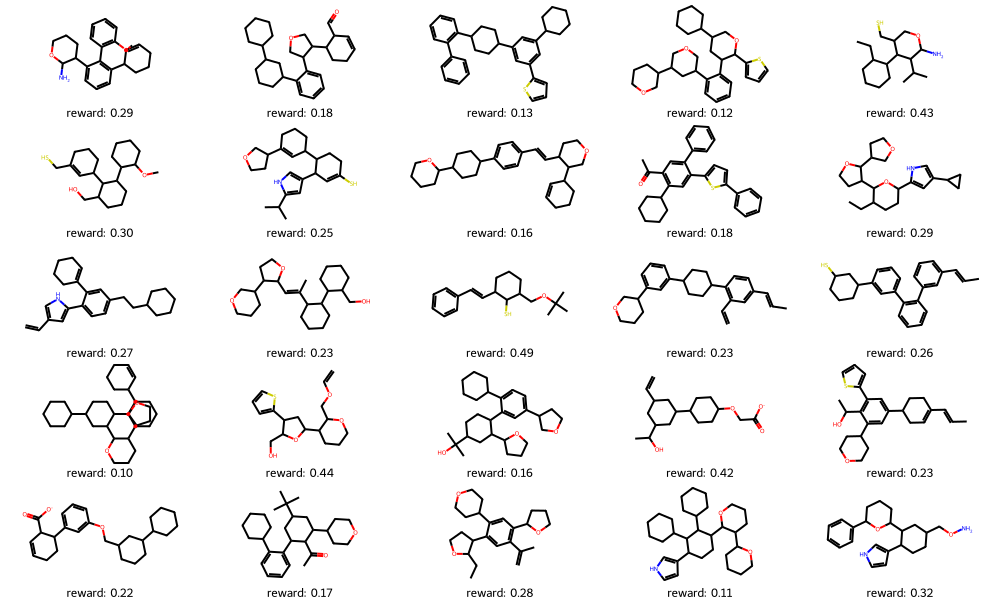

In [31]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index])
        index += 1 
    else:
        rewards.append(-1)

MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==-1 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])


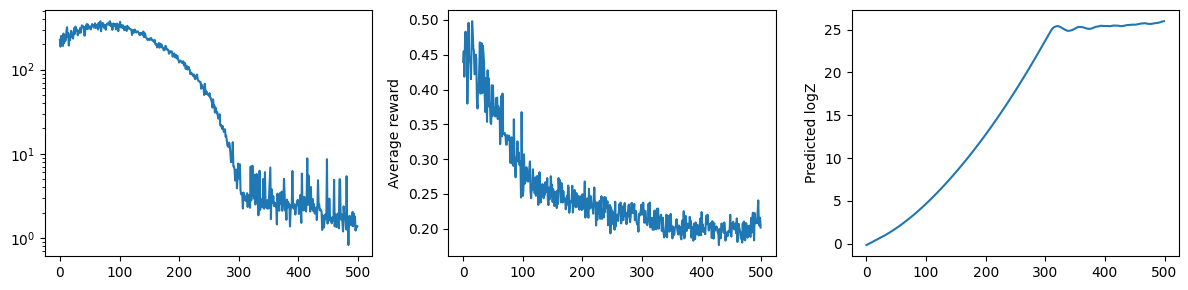

In [32]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()

In [27]:
"""# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index])
        index += 1 
    else:
        rewards.append(-1)

MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==-1 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])"""

"# Generate molecules\ntrajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)\nobjs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]\nobj_props, is_valid = trial.task.compute_obj_properties(objs)\nlog_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)\nindex = 0\nrewards = []\nfor i in is_valid:\n    if i:\n        rewards.append(list(log_rewards)[index])\n        index += 1 \n    else:\n        rewards.append(-1)\n\nMolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==-1 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])"